In [1]:
!pip install awswrangler

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.4/42.4 MB 141.1 MB/s  0:00:00 eta 0:00:01
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 21.0.0
    Uninstalling pyarrow-21.0.0:
      Successfully uninstalled pyarrow-21.0.0━━━ 0/2 [pyarrow]
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [awswrangler] [awswrangler]


In [2]:
import awswrangler as wr
import pandas as pd
sql = """
SELECT
user_id, book_id, review_id, rating,
review_text, date_added, n_votes,
title, average_rating, ratings_count,
publication_year, author_names
FROM goodreads_processed.reviews_with_books_curated
WHERE date_added IS NOT NULL
AND TRY_CAST(DATE_PARSE(date_added, '%a %b %d %H:%i:%s -%H%i %Y') AS DATE) > DATE '2014-12-31'
"""
df = wr.athena.read_sql_query(
sql=sql,
database="goodreads_processed",
ctas_approach=True
)
print(len(df), "reviews loaded")
df.head()

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


4135084 reviews loaded


,user_id,book_id,review_id,rating,review_text,date_added,n_votes,title,average_rating,ratings_count,publication_year,author_names
0,ca6ef32327f7ddec5ad7152c9d28d596,30649413,a1de28d8ff051f03d206758bb7235a31,4,The Hideaway is a wonderful blending of two di...,Sun Jul 09 00:50:22 -0700 2017,0,The Hideaway,3.98,2742,2017,Lauren K. Denton
1,cf8cfe5f8549788f1c7baf88decdc7ca,8755776,c0befe18a8b2c5ba76902e7cf96a43fe,5,Awsm.....n my hatred for Sebastian's on peak. ...,Tue Jul 21 04:49:50 -0700 2015,0,"City of Lost Souls (The Mortal Instruments, #5)",4.30,306686,2012,Cassandra Clare
2,6be9fa9b8edc7fe28d94b085d01346d3,13051854,6d55d44d2382209297b6ab629f975d0e,5,I love this series! Our favorite bakers packed...,Mon Apr 18 05:07:02 -0700 2016,2,"Red Velvet Revenge (Cupcake Bakery Mystery, #4)",4.05,2203,2012,Jenn McKinlay
3,5f03f4d458fd277651e798bada88a7dc,29852265,772d53b1e2b58414620b917e25865358,4,When it comes to quirky I'm not always a fan. ...,Fri Oct 07 00:21:05 -0700 2016,1,The Dramatic Dead,4.27,11,,Bryan Nowak
4,959a46ae7162fcfda5170d19fb182483,24967405,2ca57c5f8372f25b6985527831b1a04e,3,So far my least favorite in this short series....,Tue Sep 22 06:53:21 -0700 2015,0,The Fiery Trial (Tales from the Shadowhunter A...,4.23,610,,"Cassandra Clare, Sarah Rees Brennan"


In [5]:
print(df.dtypes)
# Convert average_rating to float
df["average_rating"] = pd.to_numeric(df["average_rating"], errors="coerce")
# Convert ratings_count to int
df["ratings_count"] = pd.to_numeric(df["ratings_count"], errors="coerce")
# Convert publication_year to int (drop or NaN for bad values)
df["publication_year"] = pd.to_numeric(df["publication_year"], errors="coerce")
# Convert date_added to datetime
# df["date_added"] = pd.to_datetime(df["date_added"], errors="coerce")
# (Optional) Split author_names into list
df["author_list"] = df["author_names"].str.split(", ")
print(df.dtypes)

user_id             string[python]
book_id             string[python]
review_id           string[python]
rating                       Int32
review_text         string[python]
date_added          string[python]
n_votes                      Int32
title               string[python]
average_rating      string[python]
ratings_count       string[python]
publication_year    string[python]
author_names        string[python]
dtype: object
user_id             string[python]
book_id             string[python]
review_id           string[python]
rating                       Int32
review_text         string[python]
date_added          string[python]
n_votes                      Int32
title               string[python]
average_rating             Float64
ratings_count                Int64
publication_year           Float64
author_names        string[python]
author_list                 object
dtype: object


In [6]:
print("Total number of reviews:", len(df))

Total number of reviews: 1087492


In [7]:
rating_counts = df["rating"].value_counts().sort_index()
print("Rating distribution (1–5):")
print(rating_counts)

Rating distribution (1–5):
rating
0     34041
1     26219
2     68295
3    199959
4    365052
5    393926
Name: count, dtype: Int64


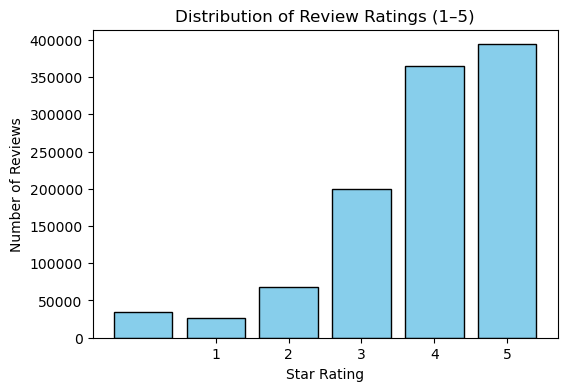

In [8]:
import matplotlib.pyplot as plt
# Plot histogram
plt.figure(figsize=(6,4))
plt.bar(rating_counts.index, rating_counts.values, color="skyblue", edgecolor="black")
plt.xlabel("Star Rating")
plt.ylabel("Number of Reviews")
plt.title("Distribution of Review Ratings (1–5)")
plt.xticks([1, 2, 3, 4, 5]) # Ensure x-axis shows 1–5
plt.show()

In [10]:
print("Average rating across reviews:", df["rating"].mean())
print("Average helpful votes per review:", df["n_votes"].mean())
print("Average book rating (metadata):", df["average_rating"].mean())

Average rating across reviews: 3.8552228430186153
Average helpful votes per review: 1.8210497180668914
Average book rating (metadata): 4.016195852475237


In [11]:
total_rows = len(df)
# Missing or empty review_text
missing_reviews = df["review_text"].isna().sum() + (df["review_text"].str.strip() == "").sum()
pct_missing_reviews = (missing_reviews / total_rows) * 100
# Missing or empty author_names
missing_authors = df["author_names"].isna().sum() + (df["author_names"].str.strip() == "").sum()
pct_missing_authors = (missing_authors / total_rows) * 100
print(f"Empty or missing review_text: {missing_reviews} out of {total_rows} ({pct_missing_reviews:.2f}%)")
print(f"Empty or missing author_names: {missing_authors} out of {total_rows} ({pct_missing_authors:.2f}%)")

Empty or missing review_text: 698 out of 1087492 (0.06%)
Empty or missing author_names: 0 out of 1087492 (0.00%)


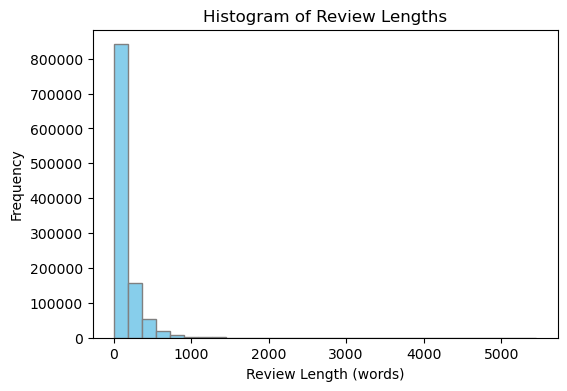

In [12]:
# Compute review length in words
df["review_length"] = df["review_text"].astype(str).apply(lambda x: len(x.split()))
# Plot histogram
plt.figure(figsize=(6,4))
plt.hist(df["review_length"],
bins=30,
color="skyblue",
edgecolor="gray")
plt.xlabel("Review Length (words)")
plt.ylabel("Frequency")
plt.title("Histogram of Review Lengths")
plt.show()

In [13]:
percentiles = df["review_length"].quantile([0.5, 0.8, 0.9, 0.99])
print(percentiles)
print("Maximum review length:", df["review_length"].max())

0.50     68.0
0.80    203.0
0.90    328.0
0.99    813.0
Name: review_length, dtype: float64
Maximum review length: 5454


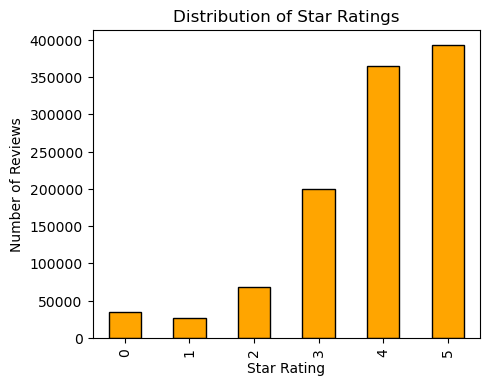

In [14]:
rating_counts = df["rating"].value_counts().sort_index()
plt.figure(figsize=(5,4))
rating_counts.plot(kind="bar", color="orange", edgecolor="black")
plt.xlabel("Star Rating")
plt.ylabel("Number of Reviews")
plt.title("Distribution of Star Ratings")
plt.show()

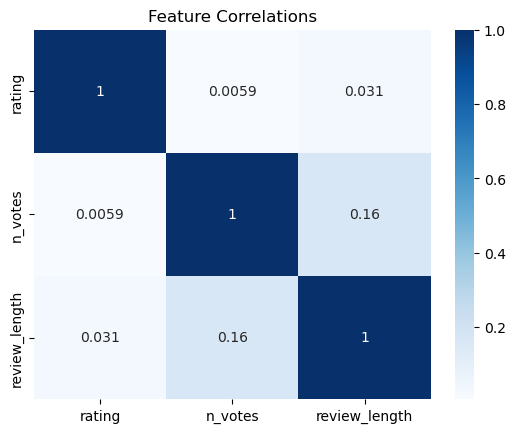

In [15]:
import seaborn as sns
numeric_cols = ["rating", "n_votes", "review_length"]
corr = df[numeric_cols].corr()
sns.heatmap(corr, annot=True, cmap="Blues")
plt.title("Feature Correlations")
plt.show()

In [16]:
print("Top 5 longest reviews (words):")
print(df["review_length"].nlargest(5).values)
print("Top 5 most voted reviews:")
print(df["n_votes"].nlargest(5).values)

Top 5 longest reviews (words):
[5454 3892 3753 3701 3692]
Top 5 most voted reviews:
<IntegerArray>
[1150, 1130, 751, 694, 679]
Length: 5, dtype: Int32


In [ ]:
#Homework 1

Top 20 Most Reviewed Books:
 title
The Girl on the Train                                                       15292
Harry Potter and the Cursed Child - Parts One and Two (Harry Potter, #8)     9110
The Martian                                                                  8617
Me Before You (Me Before You, #1)                                            7905
Red Queen (Red Queen, #1)                                                    6907
A Court of Thorns and Roses (A Court of Thorns and Roses, #1)                6856
Everything, Everything                                                       6631
A Court of Mist and Fury (A Court of Thorns and Roses, #2)                   6493
Six of Crows (Six of Crows, #1)                                              5266
Ready Player One                                                             5243
All the Light We Cannot See                                                  5181
The Nightingale                                                

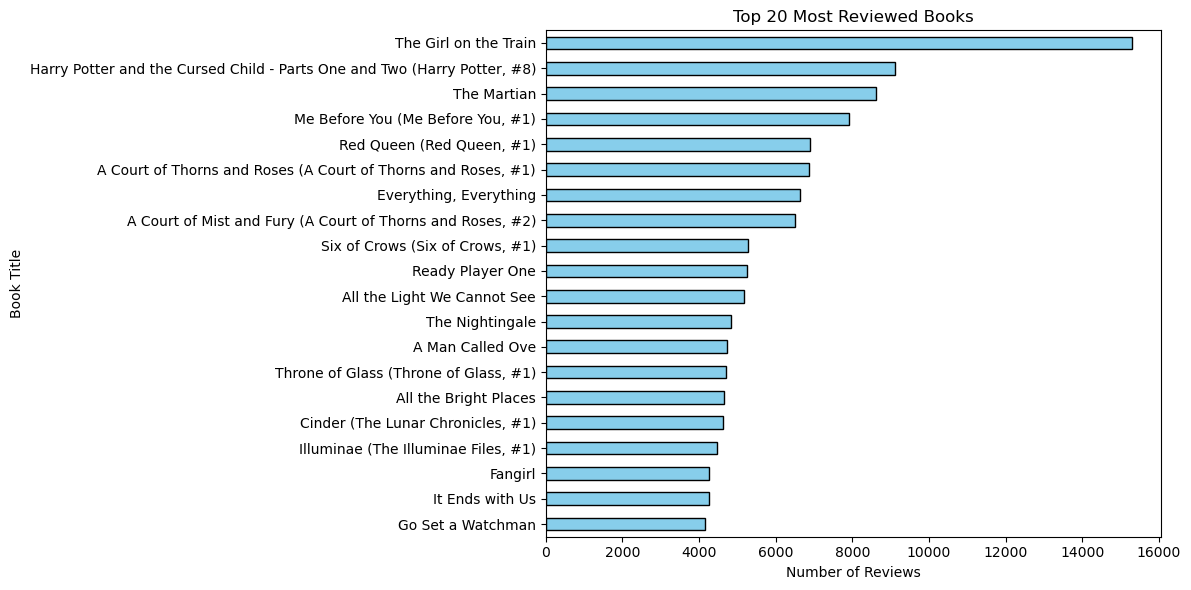

In [13]:
import matplotlib.pyplot as plt

# Count reviews per book
top_books = df["title"].value_counts().head(20)

print("Top 20 Most Reviewed Books:\n", top_books)

# Plot
plt.figure(figsize=(12,6))
top_books.sort_values().plot(kind="barh", color="skyblue", edgecolor="black")
plt.xlabel("Number of Reviews")
plt.ylabel("Book Title")
plt.title("Top 20 Most Reviewed Books")
plt.tight_layout()
plt.show()


publication_year
        3.944936
1           4.75
10           4.0
1014         3.5
1015    4.333333
          ...   
7       4.458333
8            3.0
8017    3.571429
9            4.2
973          4.0
Name: rating, Length: 328, dtype: Float64


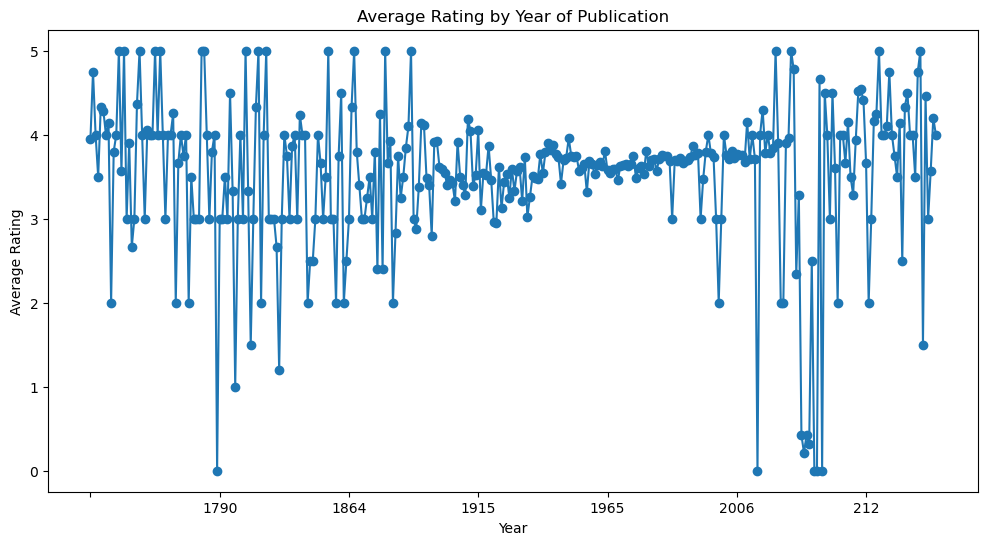

In [14]:
# Group by year of publication
import matplotlib.pyplot as plt
avg_rating_year = df.groupby('publication_year')['rating'].mean()

# Show
print(avg_rating_year)

# Plot
avg_rating_year.plot(kind='line', figsize=(12,6), marker='o')
plt.title('Average Rating by Year of Publication')
plt.xlabel('Year')
plt.ylabel('Average Rating')
plt.show()


In [8]:
print(df['publication_year'].dtype)


string


publication_year
1500.0         5.0
1566.0         4.0
1599.0         3.0
1603.0         4.0
1623.0         4.0
            ...   
2019.0    0.422572
2020.0    0.212766
2021.0    0.428571
2022.0    0.322581
2025.0         2.5
Name: rating, Length: 237, dtype: Float64


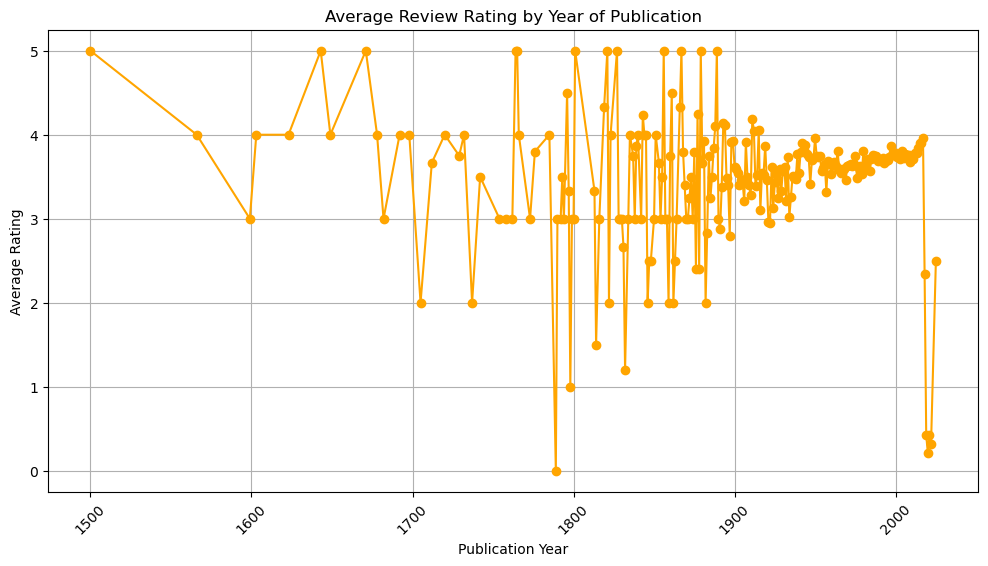

In [16]:
import matplotlib.pyplot as plt
import pandas as pd

# Convert to numeric and filter realistic years
df["publication_year"] = pd.to_numeric(df["publication_year"], errors="coerce")
df_filtered = df[(df["publication_year"] >= 1450) & (df["publication_year"] <= 2025)]

# Compute average rating per year on filtered data
avg_rating_by_year = df_filtered.groupby("publication_year")["rating"].mean()

# Show values
print(avg_rating_by_year)

# Plot
plt.figure(figsize=(12,6))
avg_rating_by_year.plot(kind='line', marker='o', color='orange')
plt.xlabel("Publication Year")
plt.ylabel("Average Rating")
plt.title("Average Review Rating by Year of Publication")
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


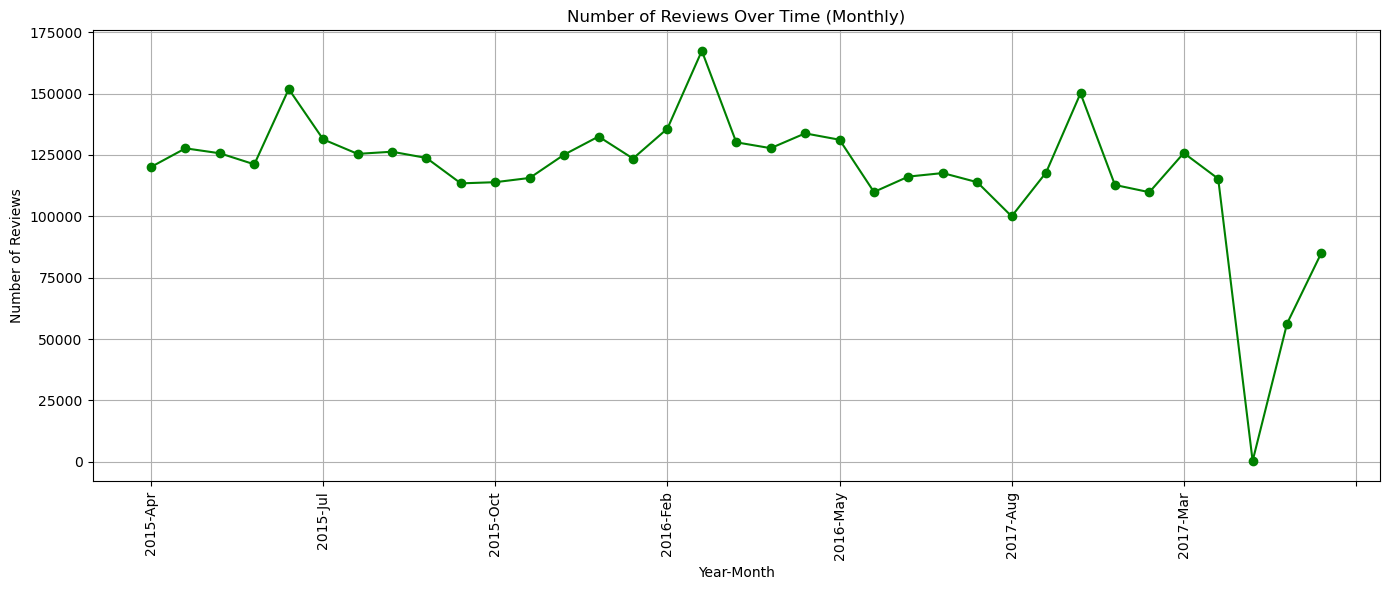

In [16]:
# Extract year-month from date string
df["year_month"] = df["date_added"].str.slice(-4) + "-" + df["date_added"].str.slice(4,7)

# Count reviews per month
monthly_counts = df["year_month"].value_counts().sort_index()

plt.figure(figsize=(14,6))
monthly_counts.plot(kind="line", marker='o', color='green')
plt.xlabel("Year-Month")
plt.ylabel("Number of Reviews")
plt.title("Number of Reviews Over Time (Monthly)")
plt.xticks(rotation=90)
plt.grid(True)
plt.tight_layout()
plt.show()


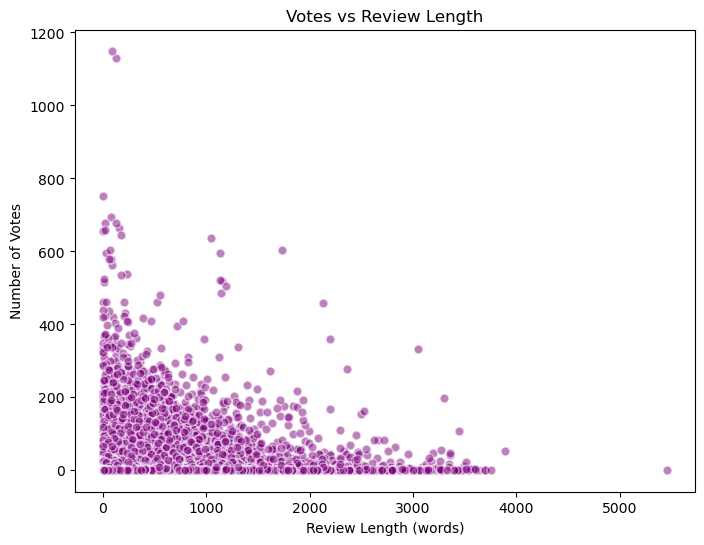

In [20]:
plt.figure(figsize=(8,6))
plt.scatter(df["review_length"], df["n_votes"], alpha=0.5, color="purple", edgecolor="w", s=40)
plt.xlabel("Review Length (words)")
plt.ylabel("Number of Votes")
plt.title("Votes vs Review Length")
plt.show()


In [ ]:
import matplotlib.pyplot as plt

# Recreate review length (number of words)
df["review_length"] = df["review_text"].str.split().str.len()

# Scatterplot
plt.figure(figsize=(10,6))
plt.scatter(df['n_votes'], df['review_length'], alpha=0.5, color='blue')
plt.title('Votes vs Review Length')
plt.xlabel('Number of Votes')
plt.ylabel('Review Length (words)')
plt.grid(True)
plt.show()


0

In [21]:
!pip install wordcloud matplotlib

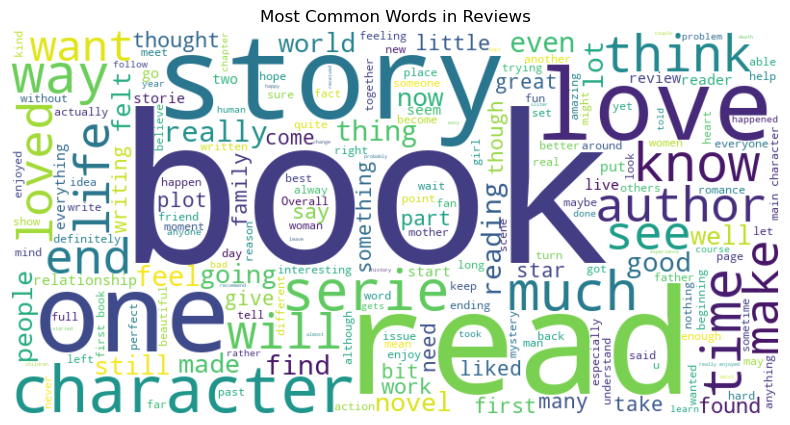

In [22]:
from wordcloud import WordCloud
text = " ".join(df["review_text"].dropna().astype(str).sample(50000, random_state=42))
wordcloud = WordCloud(width=800, height=400, background_color="white").generate(text)
plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Most Common Words in Reviews")
plt.show()

In [23]:
# Count reviews per rating
class_counts = df["rating"].value_counts().sort_index()
print("Rating distribution:\n", class_counts)

Rating distribution:
 rating
0     34041
1     26219
2     68295
3    199959
4    365052
5    393926
Name: count, dtype: Int64


In [24]:
# Simple CI metric: proportion of majority class
ci_score = class_counts.max() / class_counts.sum()
print(f"Class Imbalance (CI) score: {ci_score:.2f}")

Class Imbalance (CI) score: 0.36


Rating distribution:
 rating
0     34041
1     26219
2     68295
3    199959
4    365052
5    393926
Name: count, dtype: Int64
Class Imbalance (CI) score: 0.36


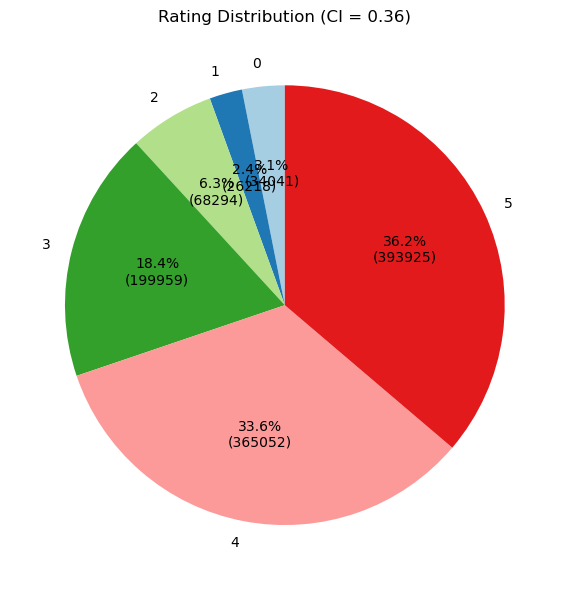

In [27]:
import matplotlib.pyplot as plt
# Rating counts
class_counts = df["rating"].value_counts().sort_index()
total_reviews = class_counts.sum()
# Compute CI score (majority proportion)
ci_score = class_counts.max() / total_reviews
print("Rating distribution:\n", class_counts)
print(f"Class Imbalance (CI) score: {ci_score:.2f}")
# Plot as a pie chart
plt.figure(figsize=(6,6))
plt.pie(
class_counts,
labels=class_counts.index,
autopct=lambda p: f'{p:.1f}%\n({int(p*total_reviews/100)})',
startangle=90,
colors=plt.cm.Paired.colors
)
plt.title(f"Rating Distribution (CI = {ci_score:.2f})")
plt.tight_layout()
plt.show()



In [ ]:
# Lambda functions are concise, inline functions for small tasks.

# In Pandas, they are handy for column transformations, conditional operations, and quick feature engineering without writing a full function.

In [29]:
# Create a new column using a lambda function
df["review_length_category"] = df["review_length"].apply(lambda x: "Long" if x > 100 else "Short")

# Check result
df[["review_length", "review_length_category"]].head()


,review_length,review_length_category
0,319,Long
1,230,Long
2,22,Short
3,105,Long
4,4,Short


In [17]:
df['review_text'].isnull().sum()

0